## Introduction

Given the shortage of antibiogram images for training, I created this notebook to produce synthetic images of antibiograms.<br>

The synthetic images will be generated using foreground images and paste them into a background image.<br>  

Foreground images usually contains one of the following:
* A  single type of "antimicrobial disk" 
* A figure of "zone of inhibition".  In each figure of "zone of inhibition", it also contains an "antimicrobial disk" at its center.<br>

Background images, on the other hand, contains a single "Petri dish".<br>

In the first part of this notebook, I pasted as foreground two PNG formatted images, one of a single disk and a second image of a zone of inhibition.   The background was a larger image of a "Petri dish". Foreground images must be smaller than the background images for this to work.<br>

To see clearly what I mean, please go ahead execute the cells below and on the "Visualize Dataset" section, you will see the foreground and background images mentioned above.<br>

The second part of this notebook will contains the codes to find the contours, segmentation and bounding boxes of the "antimicrobial disks" and "zone of inhibition(with their respective antimicrobial disks").<br>

And in the final part, I converted all the data found in the second part into JSON format file.<br>

**Note: foreground and background images were created using GIMP.  This process was not included in this repo.  For more information, please see in the reference section at the end of the README page.**
    

#### Clone and Install

In [ ]:
# Clone this repo.
!git clone https://github.com/chho-work/biovision.git

Cloning into 'biovision'...
remote: Enumerating objects: 287, done.
remote: Counting objects: 100% (287/287), done.
remote: Compressing objects: 100% (220/220), done.
remote: Total 287 (delta 102), reused 215 (delta 54), pack-reused 0
Receiving objects: 100% (287/287), 3.38 MiB | 6.85 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [ ]:
# Optional: install mypy lib
#!pip install -q mypy

In [ ]:
# Install Detectron2
# Remember to restart the runtime when you install it for the first time. 
# Install only once per session.
!pip install -q git+https://github.com/facebookresearch/fvcore.git
!git clone -q https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

## Setup

### Import Library

In [ ]:
import os
import random
import numpy as np
import json
import pandas as pd
from skimage import measure
from shapely.geometry import Polygon, MultiPolygon

from pathlib import Path
from PIL import Image
from typing import Tuple, List, Callable

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.pyplot import imshow
%matplotlib inline

### Path to Data

In [ ]:
# base directory for images
base_path_image = Path('/content/biovision/data/images')

# annotation directory for annotated data
coco_annot_path = base_path_image.joinpath('coco_annotation')
coco_annot_path.mkdir(parents=True, exist_ok=True)

# background image directory
back_path = base_path_image.joinpath('background')

# foreground image directory
fore_path = base_path_image.joinpath('foreground')

# output file directory
output_path = base_path_image.joinpath('output')

# mask image directory
mask_path = base_path_image.joinpath('masks')
mask_path.mkdir(parents=True, exist_ok=True)

# train directory containing all the training images
train_path = base_path_image.joinpath('train')
train_path.mkdir(parents=True, exist_ok=True)

### Clean Up Directories
* To be used in errors related to [".ipynb checkpoints"](https://stackoverflow.com/questions/46421663/what-are-jupyter-notebook-checkpoint-files-for)".
* This cell removes "ipynb checkpoints" , when it appears in the directories.


In [ ]:
# Note: use the below commands to remove ".ipynb_checkpoints" if it exists.
!rm -r /content/BIODL/data/annotations/.ipynb_checkpoints
!rm -r /content/BIODL/data/images/.ipynb_checkpoints
!rm -r /content/BIODL/data/images/background/.ipynb_checkpoints
!rm -r /content/BIODL/data/images/foreground/.ipynb_checkpoints
!rm -r /content/BIODL/data/images/output/.ipynb_checkpoints
!rm -r /content/BIODL/data/images/sample/.ipynb_checkpoints
!rm -r /content/BIODL/data/images/disks/.ipynb_checkpoints

rm: cannot remove '/content/BIODL/data/annotations/.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/BIODL/data/images/.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/BIODL/data/images/background/.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/BIODL/data/images/foreground/.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/BIODL/data/images/output/.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/BIODL/data/images/sample/.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/BIODL/data/images/disks/.ipynb_checkpoints': No such file or directory


## Utilities

#### Type Checking(Optional)
* Example of data type checking using ["mypy"](https://docs.python.org/3/library/typing.html).
* "mypy" still not supported in Colab.  But it can be useful if you decide to convert to script.
* Not strictly necessary that you use the following cells.  
* Not working in every functions of this nb.


In [ ]:
# For type checking using Python "mypy".
%%writefile type_checking.py
import os
import random
import numpy as np
import json
import pandas as pd
from skimage import measure
from shapely.geometry import Polygon, MultiPolygon

from pathlib import Path
from PIL import Image

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.pyplot import imshow

from typing import Dict, List, Set, Tuple

def displaySingleImage(pathName:Path, figsize: Tuple[int, int] = (6, 6)) -> Tuple[plt.show]:
    _img = str(pathName)
    _image = mpimg.imread(_img)
    plt.figure(figsize=figsize)
    plt.imshow(_image)
    plt.title(f'File name: {pathName.name}\nImage size h x w x c {_image.shape}', 
              loc='left', 
              fontsize=13)
    return  plt.show()  

# Purposely gave the wrong data type parameter.
displaySingleImage("monkey", figsize=(3.8, 3))

Overwriting type_checking.py


In [ ]:
# Execute "mypy" on the toy sample.
!mypy type_checking.py

# Some errors are related to no third party library support.
# https://mypy.readthedocs.io/en/stable/running_mypy.html#:~:text=If%20you%20are%20getting%20a%20%E2%80%9CSkipping%20analyzing%20X%3A%20found%20module,but%20no%20corresponding%20type%20hints.&text=Searching%20to%20see%20if%20there,to%20your%20third%20party%20library.

type_checking.py:3: error: Skipping analyzing 'numpy': found module but no type hints or library stubs
type_checking.py:3: note: See https://mypy.readthedocs.io/en/latest/running_mypy.html#missing-imports
type_checking.py:5: error: Skipping analyzing 'pandas': found module but no type hints or library stubs
type_checking.py:6: error: Skipping analyzing 'skimage': found module but no type hints or library stubs
type_checking.py:7: error: Skipping analyzing 'shapely.geometry': found module but no type hints or library stubs
type_checking.py:10: error: Skipping analyzing 'PIL': found module but no type hints or library stubs
type_checking.py:12: error: Skipping analyzing 'matplotlib.image': found module but no type hints or library stubs
type_checking.py:12: error: Skipping analyzing 'matplotlib': found module but no type hints or library stubs
type_checking.py:13: error: Skipping analyzing 'matplotlib.pyplot': found module but no type hints or library stubs
type_checking.py:14: error: Sk

#### General Utils
* List paths
* Display image
* Create random coordinates

In [ ]:
# Iterate over the files of a directory and filter in a list.
Path.ls = lambda x: sorted(list(x.iterdir())) 

# Displays a single image given the path to image.  Change figure size(optional) with parameter figsize.
# Returns a displayed image with file name, and image size.

def displaySingleImage(pathName:Path, figsize:Tuple[int, int] = (6, 6)) -> Callable:
    _img = str(pathName)
    _image = mpimg.imread(_img)
    plt.figure(figsize=figsize)
    plt.imshow(_image)
    plt.title(f'File name: {pathName.name}\nImage size h x w x c {_image.shape}', 
              loc='left', 
              fontsize=13)
    return plt.show()  # plt.show() removes <matplotlib.image.AxesImage...>

# Create a series of coordinates given the initial coordinate(init_x, init_y).  
# Create a series in the X-axis using axis="x" or in the Y-axis using axis="y".  
# Generate the number of coordinates with generate=<number of coordinates>
# Returns a list with the coordinates. 
def series(axis:str, init_x:int, init_y:int, generate:int) -> list:
    _series = []
    for i in range(generate):
        _result = []
        if axis=='x' and generate > 0:
            _range = range((init_x), (init_x + generate))
            _coordinate = [init_x + i, init_y]
        elif axis=='y' and generate > 0:
            _range = range((init_y), (init_y + generate))
            _coordinate = [init_x, init_y + i]
        elif axis=='x' and generate == 0:
            _coordinate = []
        elif axis=='y' and generate == 0:
            _coordinate = []
        else:
            assert axis=='x' or axis=='y', "Please choose x or y."
                    
        _coord_0 = _coordinate[0]
        _result.append(_coord_0)
        _coord_1 = _coordinate[1]
        _result.append(_coord_1)    
        _series.append(_result)
    return _series

# Get the random generated coordinates, given the initial xy coordinates.
# Choose the number of coordinates to create with x_generate and y_generate. 
# Returns a single randomly generated coordinate. 
def getRandomCoordinate(init_x:int, init_y:int, x_generate:int, y_generate:int) -> Tuple[int, int]:
    _coord_x = series("x", init_x, init_y, x_generate) # generate x-axis coordinates
    _coord_y = series("y", init_x, init_y, y_generate) # generate y-axis coordinates
    _coord = (_coord_x + _coord_y)
    # randomly choose one generated coordinate
    _random_coord = tuple(random.choice(_coord))
    return _random_coord

#### Utils to Create New Images
* Paste smaller images into a bigger one
* Create mask image
* Composite image

In [ ]:
# Find image size given path to image.
# Returns a tuple with image size
def imageSize(path2Image:Path) -> Tuple[int, int]:
    _image = Image.open(path2Image)
    return _image.size

# Create a new image with 4 channels(RGBA), of the same size as the background image.
# Paste foreground image(s) into the newly created RGBA image, at the given coordinates.
# Parameters: background image size, a list with foreground images and coordinates to paste foreground images.
# Returns an image:
#  1) of the same size as the background images
#  2) in RGBA format
#  3) with foreground images at specific coordinates
def imageNewForeground(imageSize:Callable, 
                       img_fore:List[Path], 
                       coordinates:Tuple[int, int]):
    # Newly created image in black color with the size of background image.
    new_fore = Image.new("RGBA", imageSize, color=(0, 0, 0, 0))
    # Lock foreground images with coordinates
    match = zip(img_fore, coordinates)
    for fore, coord in match:
        # Open foreground image.
        fore_img = Image.open(fore)
        # Paste foreground to background image in the given coordinate.
        new_fore.paste(fore_img, tuple(coord))
    return new_fore

# Create a single channel image(greyscale) of the same size as the background image.
# Paste foreground image(s) in alpha channel into the newly created greyscale image, at the given coordinates.
# Parameters: background image size, a list with foreground images, coordinates to paste foreground images and file name.
# Returns a mask image:
#  1) of the same size as the background images
#  2) with foreground images at specific coordinates
#  3) image is saved at mask_path.
def imageNewMask(imageSize:Callable, 
                 img_fore:List[Path], 
                 coordinates:Tuple[int, int], fname_mask:str):
    
    # Create a 8-bit pixels(range 0-255), black color image with the same size as background image.
    new_mask = Image.new("L", imageSize, color=0)
    coordinates = list(coordinates)
    match = zip(img_fore, coordinates)

    for fore, coord in match:
        fore_img = Image.open(fore)
        # Get the alpha channel image.
        fore_img_mask = fore_img.getchannel(3)
        # Paste the foreground alpha into the new mask.
        new_mask.paste(fore_img_mask, tuple(coord))

    _path_mask = mask_path.joinpath(fname_mask)
    new_mask.save(_path_mask)
    return new_mask, _path_mask

# Create a new composited image using transparent mask
# Paste background image with generated images from imageNewForeground() and imageNewMask().
# Parameters: image generated from imageNewForeground(), background image paths, 
#             image generated from imageNewMask()and file name.
# Returns a composited image:
#  1) of the same size as the background images
#  2) composited with foreground and mask images 
#  3) image is saved at train_path.
def imageNewComposite(imageNewForeground:Callable, 
                      pathBackgroundImage:Path, 
                      imageNewMask:Callable, 
                      fname_composite:str):
    # Open a background image
    back = Image.open(pathBackgroundImage)
    # Composite image is blended from a foreground, background and mask, all of the same size.
    composite = Image.composite(imageNewForeground, back, imageNewMask)
    # Save the new composited image.
    _path_composite = train_path.joinpath(fname_composite)
    composite.save(_path_composite)
    return _path_composite, _path_composite


#### Utils for Contours, Segmentation and BBox
* Find figure contours
* Convert contours to segmentation
* Find bounding box(bbox)

In [ ]:
# Find object contours of foreground image. 
def findContours(imageSize:Callable, pathForegroundImage:Path, coordinates:Tuple[int, int]):
    _new_mask = Image.new("L", imageSize, color=0)
    _fore_img = Image.open(pathForegroundImage)
    _fore_img_mask = _fore_img.getchannel(3)
    _new_mask.paste(_fore_img_mask, (coordinates))
    _new_fname = pathForegroundImage.stem + ".png"
    _path_mask = mask_path.joinpath(_new_fname)
    _new_mask.save(_path_mask)
    contours = measure.find_contours(_new_mask, 0.8)
    new_contours = []
    for cont in contours:
        for i in range(len(contours[0])):
            _contours = (cont[i][1], cont[i][0])
            new_contours.append(_contours)

    new_contours_array = np.array(new_contours)
    re = new_contours_array.shape[0]
    new_contours_array = new_contours_array.reshape(-1, re, 2)

    return new_contours_array, new_contours_array.size, _path_mask

# Convert contours to segmentation given 
def contours2Segmentations(contours_array, tolerance:int=1.0, preserve_topology:bool=False):
    segmentations = []
    polygons = []

    for contour in contours_array:
        poly = Polygon(contour)
        poly = poly.simplify(tolerance, preserve_topology=preserve_topology)
        polygons.append(poly)
        seg = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(seg)

    return polygons, segmentations

# Find bbox of the given polygon.
def seg2BBoxArea(polygons):
    multi_poly = MultiPolygon(polygons)
    x, y, max_x, max_y = multi_poly.bounds
    width = max_x - x
    height = max_y - y
    bbox = [x, y, width, height]
    area = multi_poly.area
    
    return [bbox, area]

#### Utils to Create JSON 
* Create dictionaries to compose into JSON format

In [ ]:
# Add "images" to dict. 
def addImagesDict(pathComposite:Path, fileName:str, image_id:int) -> dict:
    _image = mpimg.imread(pathComposite)
    height, width, _ = _image.shape
    return {"images": [{"file_name": fileName, "id": image_id, "height": height, "width": width}]}

# Add "categories" to dict
def addCategoriesDict(supercategory:str, category_id:int, category_name:str) -> dict:
    return {"categories": [{"supercategory": supercategory, "id": category_id, "name": category_name}]}

# Add "annotations" to dict
def addAnnotationsDict(segmentation:list, 
                       iscrowd:int, 
                       area:float, 
                       image_id:int, 
                       bbox:list, 
                       category_id:int, 
                       id:int) -> dict:
    return {"annotations": [{"segmentation": segmentation, "iscrowd": iscrowd, "area": area, "image_id":image_id, "bbox": bbox, "category_id": category_id, "id": id}]}    


## Visualize Dataset

* First we list all image files in foreground and background directories.
* Visualize all images in these directories.

In [ ]:
# List foreground dir
print(f'Total of {len(fore_path.ls())} images')
fore_path.ls()

Total of 3 images


[PosixPath('/content/biovision/data/images/foreground/disk_AML25.png'),
 PosixPath('/content/biovision/data/images/foreground/zone_CT25.png'),
 PosixPath('/content/biovision/data/images/foreground/zone_CT25_disk.png')]

In [ ]:
# List background dir
print(f'Total of {len(back_path.ls())} images')
back_path.ls()

Total of 1 images


[PosixPath('/content/biovision/data/images/background/9_antibiogram_empty_petri.jpg')]

As mentioned in the introduction, the following four cells contains images of:<br>

1) Foreground image 1: single antimicrobial disk image<br>
2) Foreground image 2: zone of inhibition image with its center containing an antimicrobial disk<br>
3) The mentioned antimicrobial disk in image 2 in an stand alone image<br>
4) Background image: Petri dish image<br>

We will paste 1) and 2) on 4).  We can find the contours of foreground images 1) and 2).  But we also need the contour of the disk at the center of the zone of inhibition, image 2).  Therefore, I had to create a separate image of the disk at the center of zone of inhibition, image 3).<br>

With images mentioned above, we can find contours of:<br>
a) Foreground image 1, single disk<br>
b) Foreground image 2, zone of inhibition<br>
c) Foreground image 2, disk at the center of zone of inhibition<br>



Please note the following:
* The size of second image(zone of inhibition) and the size of third image(antimicrobial disk at the center of the zone of inhibition) must be of the same size.
* You can add more than one single antimicrobial disks, but you need to make sure that all antimicrobial disk foreground images you add have to be the same sizes.
* The same size rule also applies for zone of inhibition images.     

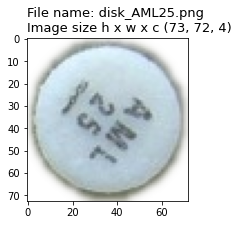

In [ ]:
# This is a foreground image of a single type of antimicrobial disk. 
# I also call this type of foreground image, disk/only images.
fore1 = fore_path.ls()[0]
displaySingleImage(fore1, figsize=(3, 3))

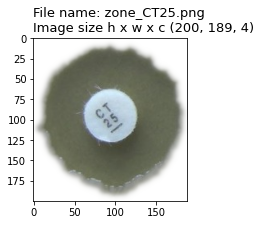

In [ ]:
# This is zone of inhibition type foreground image.  
# At its center, it also contains an antimicrobial disk.
# I also called this type of image zone images.   
fore2 = fore_path.ls()[1]
displaySingleImage(fore2, figsize=(3, 3))

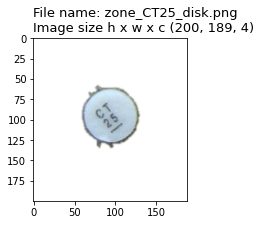

In [ ]:
# In this foreground image, I displayed the previous image without zone of inhibition.
# In another words, I showed only the antimicrobial disk at the center of the previous zone of inhibition image.
# I also call this disk/zone images.
fore3 = fore_path.ls()[2]
displaySingleImage(fore3, figsize=(3, 3))

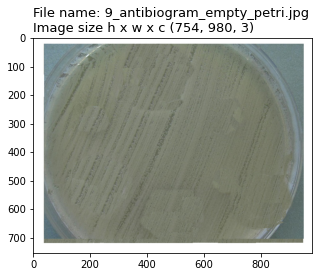

In [ ]:
# background image
back = back_path.ls()[0]
displaySingleImage(back, figsize=(5, 5))

## Synthetic Image

### Create Synthetic Image

In this section:<br>
* Generate coordinates to paste the different foreground images.
* Paste different foreground images into a background image.
* Composite a synthetic image for foreground, background and mask.

In [ ]:
# Paths to foreground and backgrond images
AML25_disk = fore_path.ls()[0] # foreground -> coord_AML25
CT25_zone = fore_path.ls()[1] # foreground -> coord_CT25
CT25_disk_zone = fore_path.ls()[2] # foreground -> coord_CT25, use the same coordinate as CT25_zone
back_petri = back_path.ls()[0] # background

Note:<br> 
***Remember to give "image_id" a new number every time you want to create a new synthetic image.***

In [ ]:
# Select an id number.
image_id = 1 # must be int
# Declare image name, to be saved in train directory and used for training
synthetic_fname = "synthetic_antibiogram_" + str(image_id) + ".jpg"
# Declare image name, to be saved in mask directory
mask_fname = "synthetic_mask_" + str(image_id) + ".png"
# Declare image name, to be saved in coco annotation directory
json_fname = "synthetic_json_" + str(image_id) + ".json"

**Generate new sets of coordinate by executing the following cell.**

In [ ]:
# Generate random coordinates.
# To generate another set of random coordinates, re-execute this cell.
coord_AML25 = getRandomCoordinate(init_x=310, init_y=200, x_generate=300, y_generate=1) # coordinate for disk only image
coord_CT25 = getRandomCoordinate(init_x=190, init_y=350, x_generate=100, y_generate=100) # coordinate for disk/zone + zone images

File saved in "/content/biovision/data/images/train/synthetic_antibiogram_1.jpg"


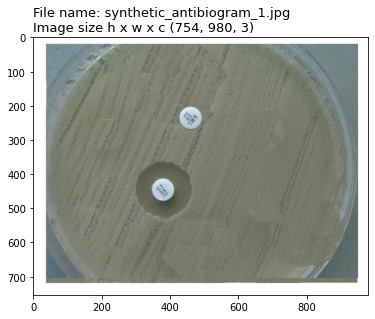

File saved in "/content/biovision/data/images/masks/synthetic_mask_1.png"


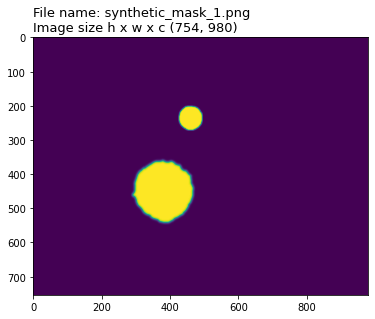

In [ ]:
# Create synthetic image and paste on the coordinates generated in above cells.
# Note: CT25_zone and CT25_disk_zone are to be pasted in the same coordinate(coord_CT25).
coordinates = [coord_AML25, coord_CT25] 
image_foreground = [AML25_disk, CT25_zone, CT25_disk_zone]

# Background image.
background_img = back_path.ls()[0]
back_size = imageSize(background_img)

# A synthetic image is generated by composing two images(new_foreground, background_img) with 
#  a mask(new_mask).  
new_foreground = imageNewForeground(back_size, image_foreground, coordinates)
new_mask, path_mask = imageNewMask(back_size, image_foreground, coordinates, mask_fname)

# Save the generated image in train dir. 
path_composite_img, path_train = imageNewComposite(new_foreground, 
                                                   background_img, 
                                                   new_mask, 
                                                   synthetic_fname)

# Synthetic image
print(f'File saved in "{path_train}"')
displaySingleImage(path_composite_img)

# Mask of the synthetic image  
print(f'File saved in "{path_mask}"')
displaySingleImage(path_mask)

### Segmentation and BBox 
In this section:<br>
* Find contour for each foreground image.
* Convert the contours into segmentation.
* Find each segmentation's bbox.

We have 3 foreground images in 2 coordinates.  Please note that: 
* Foreground images CT25_zone and CT25_disk_zone will use the same coordinate.
* This is due to the fact that CT25_disk_zone image resides on top of CT25_zone.  In another words, they are part of the same image.

#### Foreground Image AML_25 Segmentation and BBOX

Segmentation AML25: [[479.0, 272.2, 484.0, 269.2, 496.2, 256.0, 496.2, 217.0, 483.0, 201.8, 479.0, 199.8, 446.0, 199.07272727272726, 440.0, 200.8, 429.8, 210.0, 424.8, 217.0, 424.8, 254.0, 427.8, 259.0, 442.0, 272.2, 479.0, 272.2]]
BBox coordinates AML25: [424.8, 199.07272727272726, 71.39999999999998, 73.12727272727273]
BBox area AML25: 4658.761818181816


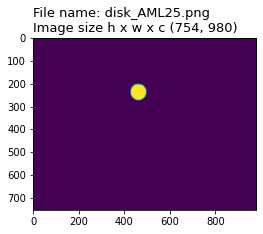

In [ ]:
# Foreground image AML_25(disk/only) in coordinate AML_25
contours_AML25, size_AML25, path_mask_AML25 = findContours(back_size, image_foreground[0], coordinates[0])
polygons_AML25, segment_AML25 = contours2Segmentations(contours_AML25)
print(f'Segmentation AML25: {segment_AML25}')
bbox_AML25, area_AML25 = seg2BBoxArea(polygons_AML25)
print(f'BBox coordinates AML25: {bbox_AML25}')
print(f'BBox area AML25: {area_AML25}')
displaySingleImage(path_mask_AML25, figsize=(4, 4))

#### Foreground Image CT25 Segmentation and BBOX
* Foreground images:  CT25_zone and CT25_disk_zone will use the same coordinate.
* This is due to the fact that CT25_disk_zone image resides on top of CT25_zone.  In another words, they are part of the same image.

Segmentation CT25 Zone: [[405.0, 549.2, 417.0, 540.2, 442.0, 526.2, 450.2, 518.0, 462.2, 501.0, 466.2, 491.0, 474.2, 478.0, 474.84, 434.0, 472.2, 405.0, 466.2, 396.0, 457.0, 386.8, 452.0, 381.8, 444.0, 377.8, 431.0, 363.8, 418.0, 358.8, 409.0, 352.8, 402.0, 351.8, 398.0, 353.8, 390.0, 353.8, 382.0, 349.8, 372.0, 351.8, 359.0, 351.8, 345.0, 357.8, 327.0, 369.8, 320.0, 372.8, 307.0, 382.8, 297.8, 394.0, 293.8, 402.0, 286.8, 424.0, 285.8, 471.0, 290.8, 478.0, 292.8, 486.0, 297.8, 495.0, 308.8, 507.0, 313.8, 515.0, 328.0, 527.2, 337.0, 531.2, 350.0, 540.2, 362.0, 544.2, 368.0, 549.2, 405.0, 549.2]]
BBox coordinates CT25 Zone: [285.8, 349.8, 189.03999999999996, 199.40000000000003]
BBox area CT25 Zone: 29577.839999999997


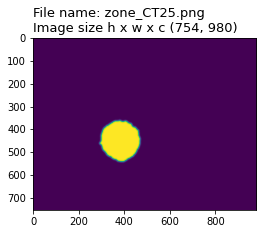

In [ ]:
# Foreground image CT25(zone) in coordinate CT_25
contours_CT25_zone, size_CT25_zone, path_mask_CT25_zone = findContours(back_size, image_foreground[1], coordinates[1])
polygons_CT25_zone, segment_CT25_zone = contours2Segmentations(contours_CT25_zone)
print(f'Segmentation CT25 Zone: {segment_CT25_zone}')
bbox_CT25_zone, area_CT25_zone = seg2BBoxArea(polygons_CT25_zone)
print(f'BBox coordinates CT25 Zone: {bbox_CT25_zone}')
print(f'BBox area CT25 Zone: {area_CT25_zone}')
displaySingleImage(path_mask_CT25_zone, figsize=(4, 4))

Segmentation CT25 Disk/Zone: [[383.0, 486.6, 386.0, 481.9, 392.0, 481.8666666666667, 398.0, 479.6, 409.8, 469.0, 413.6, 464.0, 417.8666666666667, 444.0, 412.6, 428.0, 397.0, 411.4, 386.0, 408.4, 370.2, 409.0, 364.0, 406.1333333333333, 359.4, 410.0, 359.8, 414.0, 354.0, 414.1333333333333, 351.4, 416.0, 352.1142857142857, 422.0, 344.1333333333333, 434.0, 343.1333333333333, 450.0, 346.4, 463.0, 350.0, 468.2, 361.0, 476.73333333333335, 361.4, 483.0, 365.0, 486.6, 368.0, 486.6, 371.0, 480.9, 376.2, 483.0, 379.0, 486.6, 383.0, 486.6]]
BBox coordinates 5 Disk/Zone: [343.1333333333333, 406.1333333333333, 74.73333333333335, 80.4666666666667]
BBox area CT25 Disk/Zone: 4469.251428571431
/content/biovision/data/images/masks/zone_CT25_disk.png


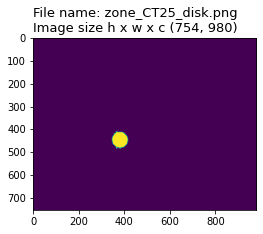

In [ ]:
# Foreground image CT25(disk/zone) in coordinate CT_25
contours_CT25_diskZone, size_CT25_diskZone, path_mask_CT25_diskZone = findContours(back_size, image_foreground[2], coordinates[1])
polygons_CT25_diskZone, segment_CT25_diskZone = contours2Segmentations(contours_CT25_diskZone)
print(f'Segmentation CT25 Disk/Zone: {segment_CT25_diskZone}')
bbox_CT25_diskZone, area_CT25_diskZone = seg2BBoxArea(polygons_CT25_diskZone)
print(f'BBox coordinates 5 Disk/Zone: {bbox_CT25_diskZone}')
print(f'BBox area CT25 Disk/Zone: {area_CT25_diskZone}')
print(path_mask_CT25_diskZone)
displaySingleImage(path_mask_CT25_diskZone, figsize=(4, 4))

### Preprocess the Data for JSON Format
* Convert segmentation and bbox points into JSON format.
* To fulfill basic COCO format requirement, the JSON file that we need to create should contain the following keys: "images", "categories" and "annotations".

#### Key: "images"
Sample:<br>
{'file_name': <fname>,
 'height': int,
 'id': int,
 'width': int} <br>
 
Important:<br>
* Check if "image_id" is correct, verify if there is any other images using the same image_id.  The values in each image_id variable must be "unique".  In another words, you CAN NOT have two image_id's with same value.  

* The same applies to "filename".

* "image_id" and "filename" should match.  There is only one "image_id" for a given "filename".

Ex:<br>
image_id = 0; synthetic_image_1.jpg<br>
image_id = 1; synthetic_image_2.jpg<br>
image_id = 2; synthetic_image_3.jpg<br>
...

In [ ]:
id_image = image_id 
filename = synthetic_fname
images_dict = addImagesDict(path_composite_img, filename, id_image)
images_dict_0 = images_dict['images'][0]
images_dict_0

{'file_name': 'synthetic_antibiogram_1.jpg',
 'height': 754,
 'id': 1,
 'width': 980}

#### Key: "categories"
Sample:<br>
{'id': 0, 'name': 'disk', 'supercategory': 'none'}<br>    

In [ ]:
# First category
supercategory = "none"
id_disk = 0
name_disk = "disk"
category_disk_dict = addCategoriesDict(supercategory, id_disk, name_disk)
disk_dict = (category_disk_dict['categories'][0])

# Second category
supercategory = "none"
id_zone = 1
name_zone = "zone"
category_zone_dict = addCategoriesDict(supercategory, id_zone, name_zone)
zone_dict = (category_zone_dict['categories'][0])

In [ ]:
# Make sure you execute this only once, otherwise it will append new categories.
categories_dict = {'categories':[]}
categories_dict['categories'].append(disk_dict)
categories_dict['categories'].append(zone_dict)

In [ ]:
cat_0 = categories_dict['categories'][0]
cat_1 = categories_dict['categories'][1]
cat_0, cat_1

({'id': 0, 'name': 'disk', 'supercategory': 'none'},
 {'id': 1, 'name': 'zone', 'supercategory': 'none'})

#### Key: "annotations"
Sample:<br>
{'area': float,
 'bbox': <[list with 4 floats coordinates]>,
 'category_id': int,
 'id': int,
 'image_id': int,
 'iscrowd': int,
 'segmentation': <[[list of floats]]>}<br>

Reminder:<br>
* category disk: 0
* category zone: 1
* iscrowd = 0

We have 3 annotations data, one for each foreground image.

In [ ]:
iscrowd = 0 # This nb does not support RLE.

In [ ]:
# Annotation for AML_25
category_id = 0 # disk image
id_annot_1 = 1
annotations_dict_AML_25 = addAnnotationsDict(segment_AML25, 
                                        iscrowd, 
                                        area_AML25, 
                                        image_id, 
                                        bbox_AML25, 
                                        category_id, 
                                        id_annot_1)

annot_dict_AML_25 = (annotations_dict_AML_25['annotations'][0])
print(annot_dict_AML_25)

{'segmentation': [[479.0, 272.2, 484.0, 269.2, 496.2, 256.0, 496.2, 217.0, 483.0, 201.8, 479.0, 199.8, 446.0, 199.07272727272726, 440.0, 200.8, 429.8, 210.0, 424.8, 217.0, 424.8, 254.0, 427.8, 259.0, 442.0, 272.2, 479.0, 272.2]], 'iscrowd': 0, 'area': 4658.761818181816, 'image_id': 1, 'bbox': [424.8, 199.07272727272726, 71.39999999999998, 73.12727272727273], 'category_id': 0, 'id': 1}


In [ ]:
# Annotation for CT25 Zone
category_id = 1 # zone image
id_annot_2 = 2
annotations_dict_CT5_zone = addAnnotationsDict(segment_CT25_zone, 
                                        iscrowd, 
                                        area_CT25_zone, 
                                        image_id, 
                                        bbox_CT25_zone, 
                                        category_id, 
                                        id_annot_2)
annot_dict_CT5_zone = (annotations_dict_CT5_zone['annotations'][0])
print(annot_dict_CT5_zone)

{'segmentation': [[405.0, 549.2, 417.0, 540.2, 442.0, 526.2, 450.2, 518.0, 462.2, 501.0, 466.2, 491.0, 474.2, 478.0, 474.84, 434.0, 472.2, 405.0, 466.2, 396.0, 457.0, 386.8, 452.0, 381.8, 444.0, 377.8, 431.0, 363.8, 418.0, 358.8, 409.0, 352.8, 402.0, 351.8, 398.0, 353.8, 390.0, 353.8, 382.0, 349.8, 372.0, 351.8, 359.0, 351.8, 345.0, 357.8, 327.0, 369.8, 320.0, 372.8, 307.0, 382.8, 297.8, 394.0, 293.8, 402.0, 286.8, 424.0, 285.8, 471.0, 290.8, 478.0, 292.8, 486.0, 297.8, 495.0, 308.8, 507.0, 313.8, 515.0, 328.0, 527.2, 337.0, 531.2, 350.0, 540.2, 362.0, 544.2, 368.0, 549.2, 405.0, 549.2]], 'iscrowd': 0, 'area': 29577.839999999997, 'image_id': 1, 'bbox': [285.8, 349.8, 189.03999999999996, 199.40000000000003], 'category_id': 1, 'id': 2}


In [ ]:
# Annotation for CT25 Disk/Zone
category_id = 0
id_annot_3 = 3
annotations_dict_CT25_diskZone = addAnnotationsDict(segment_CT25_diskZone, 
                                        iscrowd, 
                                        area_CT25_diskZone, 
                                        image_id, 
                                        bbox_CT25_diskZone, 
                                        category_id, 
                                        id_annot_3)

annot_dict_CT25_diskZone = (annotations_dict_CT25_diskZone['annotations'][0])
print(annot_dict_CT25_diskZone)

{'segmentation': [[383.0, 486.6, 386.0, 481.9, 392.0, 481.8666666666667, 398.0, 479.6, 409.8, 469.0, 413.6, 464.0, 417.8666666666667, 444.0, 412.6, 428.0, 397.0, 411.4, 386.0, 408.4, 370.2, 409.0, 364.0, 406.1333333333333, 359.4, 410.0, 359.8, 414.0, 354.0, 414.1333333333333, 351.4, 416.0, 352.1142857142857, 422.0, 344.1333333333333, 434.0, 343.1333333333333, 450.0, 346.4, 463.0, 350.0, 468.2, 361.0, 476.73333333333335, 361.4, 483.0, 365.0, 486.6, 368.0, 486.6, 371.0, 480.9, 376.2, 483.0, 379.0, 486.6, 383.0, 486.6]], 'iscrowd': 0, 'area': 4469.251428571431, 'image_id': 1, 'bbox': [343.1333333333333, 406.1333333333333, 74.73333333333335, 80.4666666666667], 'category_id': 0, 'id': 3}


### Convert to JSON Format(Customized COCO)
Now that we have "images", "categories", and "annotations" keys, we can go ahead and create JSON file that fulfills COCO format requirement.


In [ ]:
# Create an empty value dictionary with keys that you will use in you custom(COCO format) json file.
coco_json = {"images":[], "categories":[], "annotations":[]}

In [ ]:
# Append values in images key.
coco_json['images'].append(images_dict_0)
coco_json

{'annotations': [],
 'categories': [],
 'images': [{'file_name': 'synthetic_antibiogram_1.jpg',
   'height': 754,
   'id': 1,
   'width': 980}]}

In [ ]:
# Append values in categories key.
coco_json['categories'].append(cat_0)
coco_json['categories'].append(cat_1)
coco_json

{'annotations': [],
 'categories': [{'id': 0, 'name': 'disk', 'supercategory': 'none'},
  {'id': 1, 'name': 'zone', 'supercategory': 'none'}],
 'images': [{'file_name': 'synthetic_antibiogram_1.jpg',
   'height': 754,
   'id': 1,
   'width': 980}]}

In [ ]:
# Append values in annotations key.
annotations_coco = [annot_dict_AML_25, annot_dict_CT5_zone, annot_dict_CT25_diskZone]

for _annot in annotations_coco:
    coco_json['annotations'].append(_annot)

print(coco_json)

{'images': [{'file_name': 'synthetic_antibiogram_1.jpg', 'id': 1, 'height': 754, 'width': 980}], 'categories': [{'supercategory': 'none', 'id': 0, 'name': 'disk'}, {'supercategory': 'none', 'id': 1, 'name': 'zone'}], 'annotations': [{'segmentation': [[479.0, 272.2, 484.0, 269.2, 496.2, 256.0, 496.2, 217.0, 483.0, 201.8, 479.0, 199.8, 446.0, 199.07272727272726, 440.0, 200.8, 429.8, 210.0, 424.8, 217.0, 424.8, 254.0, 427.8, 259.0, 442.0, 272.2, 479.0, 272.2]], 'iscrowd': 0, 'area': 4658.761818181816, 'image_id': 1, 'bbox': [424.8, 199.07272727272726, 71.39999999999998, 73.12727272727273], 'category_id': 0, 'id': 1}, {'segmentation': [[405.0, 549.2, 417.0, 540.2, 442.0, 526.2, 450.2, 518.0, 462.2, 501.0, 466.2, 491.0, 474.2, 478.0, 474.84, 434.0, 472.2, 405.0, 466.2, 396.0, 457.0, 386.8, 452.0, 381.8, 444.0, 377.8, 431.0, 363.8, 418.0, 358.8, 409.0, 352.8, 402.0, 351.8, 398.0, 353.8, 390.0, 353.8, 382.0, 349.8, 372.0, 351.8, 359.0, 351.8, 345.0, 357.8, 327.0, 369.8, 320.0, 372.8, 307.0, 3

In [ ]:
# Save to image annotation in coco_annotation directory.
json_coco = json.loads(json.dumps(coco_json, indent=4))
synthetic_json = coco_annot_path.joinpath(json_fname)
with open(synthetic_json, 'w') as coco:
    json.dump(json_coco, coco, indent=4)

In [ ]:
# Print synthetic_json.
with open(synthetic_json) as json_file:
    data = json.load(json_file)
    for key, value in data.items():
        print(key)
        print(value)
        

images
[{'file_name': 'synthetic_antibiogram_1.jpg', 'id': 1, 'height': 754, 'width': 980}]
categories
[{'supercategory': 'none', 'id': 0, 'name': 'disk'}, {'supercategory': 'none', 'id': 1, 'name': 'zone'}]
annotations
[{'segmentation': [[479.0, 272.2, 484.0, 269.2, 496.2, 256.0, 496.2, 217.0, 483.0, 201.8, 479.0, 199.8, 446.0, 199.07272727272726, 440.0, 200.8, 429.8, 210.0, 424.8, 217.0, 424.8, 254.0, 427.8, 259.0, 442.0, 272.2, 479.0, 272.2]], 'iscrowd': 0, 'area': 4658.761818181816, 'image_id': 1, 'bbox': [424.8, 199.07272727272726, 71.39999999999998, 73.12727272727273], 'category_id': 0, 'id': 1}, {'segmentation': [[405.0, 549.2, 417.0, 540.2, 442.0, 526.2, 450.2, 518.0, 462.2, 501.0, 466.2, 491.0, 474.2, 478.0, 474.84, 434.0, 472.2, 405.0, 466.2, 396.0, 457.0, 386.8, 452.0, 381.8, 444.0, 377.8, 431.0, 363.8, 418.0, 358.8, 409.0, 352.8, 402.0, 351.8, 398.0, 353.8, 390.0, 353.8, 382.0, 349.8, 372.0, 351.8, 359.0, 351.8, 345.0, 357.8, 327.0, 369.8, 320.0, 372.8, 307.0, 382.8, 297.8,

## View Image in Detectron2
We will train, validate and perform inference on the data in Detectron2 in another nb.  To use the same library, Detectron2's Visualizers API to view the the annotated image.  

### Import Library and Visualize

In [ ]:
from detectron2.data.datasets import register_coco_instances
instance_name = "Synthetic_Image"
train_dir = str(train_path)
register_coco_instances(instance_name, 
                        {}, 
                        synthetic_json, 
                        train_path)

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [ ]:
from detectron2.data import MetadataCatalog, DatasetCatalog
metadata = MetadataCatalog.get(instance_name)
dataset_dicts = DatasetCatalog.get(instance_name)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



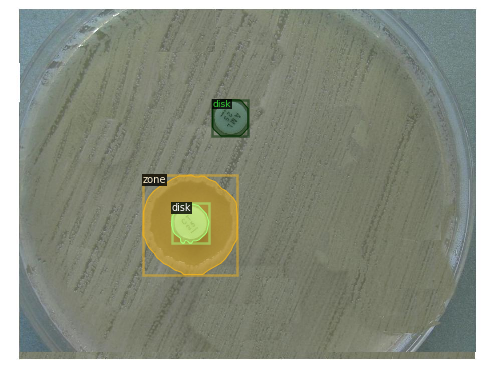

In [ ]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])
    vis.save('/content/synthetic_annotation.jpg')

### Pack Data and Upload to Local Drive
* You can download the data to your local drive or to your Grive.
* In the following cells, I zip all JSON files created when generating the synthetic images and downloaded them to my local drive.  


In [ ]:
# Zip all created contents, both images and annotations.
!zip -r /content/annotation.zip /content/biovision/data/images/coco_annotation
!zip -r /content/train.zip /content/biovision/data/images/train

  adding: content/biovision/data/images/coco_annotation/ (stored 0%)
  adding: content/biovision/data/images/coco_annotation/synthetic_json_1.json (deflated 86%)
  adding: content/biovision/data/images/train/ (stored 0%)
  adding: content/biovision/data/images/train/synthetic_antibiogram_1.jpg (deflated 4%)


In [ ]:
# Upload to your local drive
from google.colab import files
files.download("/content/train.zip")
files.download("/content/annotation.zip")

## Reference:
* https://scikit-image.org/
* https://www.immersivelimit.com/tutorials/composing-images-with-python-for-synthetic-datasets
* https://cocodataset.org/#home
* https://www.dlology.com/blog/how-to-create-custom-coco-data-set-for-instance-segmentation/